# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
from torch.autograd import Variable
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
int2dna

{0: 'N', 1: 'A', 2: 'C', 3: 'G', 4: 'T'}

In [4]:
dna2int

{'N': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

In [5]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512
set_seed(13)
def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2 : # use intseq_to_dnaseq here to convert ids back to DNA seqs 
    temp = [list(intseq_to_dnaseq(i)) for i in X_dna_seqs_train] 
    
    #step3 : # use count_cpgs here to generate labels with temp generated in step2 
    y_dna_seqs = [count_cpgs(''.join(i)) for i in temp]
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [6]:
from collections import Counter

In [7]:
counter_test = Counter(test_y)
print(counter_test)
counter_train = Counter(train_y)
print(counter_train)

Counter({5: 107, 4: 92, 6: 85, 3: 70, 7: 50, 2: 37, 8: 27, 9: 19, 1: 10, 10: 9, 11: 3, 0: 2, 12: 1})
Counter({5: 396, 4: 378, 6: 316, 3: 271, 7: 236, 2: 154, 8: 139, 9: 64, 10: 37, 1: 37, 0: 8, 11: 7, 12: 5})


In [8]:
# create data loader
class DNASeqData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

train_dataset = DNASeqData(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
test_dataset = DNASeqData(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())  

In [9]:
np.unique(test_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
np.unique(train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [11]:
# Regression Model
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
        self.fc = nn.Linear(hidden_size,self.num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(1), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(1), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        
        out = self.fc(h_out)
        out = self.relu(out)
        
        return out

In [12]:
num_epochs = 25 
learning_rate = 0.01

input_size = 128
hidden_size = 64
num_layers = 1
num_classes = 1
batch_size = 16

# creatin the torch data loader class for train and test 
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [13]:
lstm

LSTM(
  (lstm): LSTM(128, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [14]:
# Train the model
for epoch in range(num_epochs):
    EPOCH_LOSSES = 0 
    for j,(x_train,y_train) in enumerate(train_data_loader):
        x_train = x_train.unsqueeze(0)
        outputs = lstm(x_train)
        optimizer.zero_grad()
        y_train = y_train.unsqueeze(0).unsqueeze(0).permute(0,2,1)
        # print(outputs.shape,y_train.shape)
        loss = criterion(outputs, y_train)
        
        test_loss_total = 0 
        with torch.inference_mode():
            test_loss_total = 0 
            for j,(x_test,y_test) in enumerate(test_data_loader):
                x_test = x_test.unsqueeze(0)
                test_output = lstm(x_test)
                y_test = y_test.unsqueeze(0).unsqueeze(0).permute(0,2,1)
                # print(test_output.shape,y_test.shape)
                test_loss = criterion(test_output,y_test)
                test_loss_total+=test_loss.item()
                
        EPOCH_LOSSES+=loss.item() 
        loss.backward()
    
        optimizer.step()
    if epoch % 1 == 0:
        print("Epoch: %d, Train loss: %1.5f Test loss : %1.5f"  % (epoch, EPOCH_LOSSES,test_loss_total)) 

Epoch: 0, Train loss: 620.68102 Test loss : 133.03687
Epoch: 1, Train loss: 543.11131 Test loss : 134.16153
Epoch: 2, Train loss: 550.08045 Test loss : 133.13269
Epoch: 3, Train loss: 541.78793 Test loss : 134.32213
Epoch: 4, Train loss: 542.46090 Test loss : 133.09167
Epoch: 5, Train loss: 548.09221 Test loss : 134.11192
Epoch: 6, Train loss: 546.27604 Test loss : 133.02228
Epoch: 7, Train loss: 554.22282 Test loss : 133.32539
Epoch: 8, Train loss: 546.77179 Test loss : 136.41622
Epoch: 9, Train loss: 549.60507 Test loss : 133.71894
Epoch: 10, Train loss: 544.37285 Test loss : 134.76210
Epoch: 11, Train loss: 546.67286 Test loss : 134.84589
Epoch: 12, Train loss: 544.39637 Test loss : 133.54927
Epoch: 13, Train loss: 543.21342 Test loss : 137.94013
Epoch: 14, Train loss: 544.25411 Test loss : 133.08367
Epoch: 15, Train loss: 546.59130 Test loss : 140.90837
Epoch: 16, Train loss: 552.04740 Test loss : 135.45229
Epoch: 17, Train loss: 544.02684 Test loss : 137.90903
Epoch: 18, Train los

In [15]:
def single_predict(test_sample):
    with torch.inference_mode():
        observation = torch.from_numpy(test_sample).float()
        observation = observation.unsqueeze(0).unsqueeze(0)
        # print(observation.shape)
        observation_output = lstm(observation).item()
        return observation_output

In [22]:
single_predict(train_x[10])

4.976344585418701

In [23]:
def evaluate(test_sequences):
    evaluation_outputs = []
    ns = test_sequences.shape[0]
    for i in range(ns):
        # print(test_sequences[i])
        evaluation_outputs.append(single_predict(test_sequences[i]))
    return evaluation_outputs

In [24]:
outs = evaluate(test_x)

In [26]:
torch.save(lstm.state_dict(), 'model.pth')
input_size = 128
hidden_size = 64
num_layers = 1
num_classes = 1
batch_size = 16
SavedModel = LSTM(num_classes, input_size, hidden_size, num_layers)
SavedModel.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [27]:
SavedModel

LSTM(
  (lstm): LSTM(128, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

# Part 2: what if the DNA sequences are not the same length

In [60]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [61]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [62]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp =[[int2dna[j] for j in i] for i in X_dna_seqs_train]
    #step3
    y_dna_seqs =  [count_cpgs(''.join(i)) for i in temp]
    return X_dna_seqs_train, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [63]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels): 
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    def __call__(self, batch):
        # Sort the batch in descending order based on sequence length
        batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
        sequences, labels = zip(*batch)

        # Get the maximum sequence length in the batch
        max_length = max(len(seq) for seq in sequences)

        # Pad sequences to have the same length
        sequences_padded = []
        for seq in sequences:
            padding = torch.zeros(max_length - len(seq), dtype=torch.long)
            padded_seq = torch.cat((seq, padding))
            sequences_padded.append(padded_seq)
        sequences_padded = torch.stack(sequences_padded)

        # Convert labels to a tensor
        labels_tensor = torch.FloatTensor(labels)

        return sequences_padded, labels_tensor

In [75]:
set_seed(13)
dataset_train = MyDataset(train_x, train_y)
dataset_test = MyDataset(test_x, test_y)

batch_size= 16
num_epochs = 10 

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=PadSequence())
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=PadSequence())

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [79]:
for epoch in range(num_epochs):
    EPOCH_LOSSES = 0 
    for j,(x_train,y_train) in enumerate(data_loader_train):
        temp = torch.zeros(batch_size,max_len-x_train.shape[1])
        x_train = torch.cat((x_train,temp),dim=1)
        x_train = x_train.unsqueeze(0)
        outputs = lstm(x_train)
        optimizer.zero_grad()
        y_train = y_train.unsqueeze(0).unsqueeze(0).permute(0,2,1)
        loss = criterion(outputs, y_train)
        test_loss_total = 0 
        with torch.inference_mode():
            test_loss_total = 0 
            for j,(x_test,y_test) in enumerate(data_loader_test):
                temp_test = torch.zeros(batch_size,max_len-x_test.shape[1])
                x_test = torch.cat((x_test,temp_test),dim=1)
                x_test = x_test.unsqueeze(0)
                test_output = lstm(x_test)
                y_test = y_test.unsqueeze(0).unsqueeze(0).permute(0,2,1)
                # print(test_output.shape,y_test.shape)
                test_loss = criterion(test_output,y_test)
                test_loss_total+=test_loss.item()
                
        EPOCH_LOSSES+=loss.item() 
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        print("Epoch: %d, Train loss: %1.5f Test loss : %1.5f"  % (epoch, EPOCH_LOSSES,test_loss_total))  

Epoch: 0, Train loss: 428.05291 Test loss : 109.10320
Epoch: 1, Train loss: 414.96917 Test loss : 107.46736
Epoch: 2, Train loss: 409.61301 Test loss : 107.74857
Epoch: 3, Train loss: 414.21048 Test loss : 107.98451
Epoch: 4, Train loss: 416.86069 Test loss : 108.36785
Epoch: 5, Train loss: 405.69848 Test loss : 107.88763
Epoch: 6, Train loss: 409.55567 Test loss : 107.79962
Epoch: 7, Train loss: 419.92916 Test loss : 110.11218
Epoch: 8, Train loss: 416.68516 Test loss : 109.70897
Epoch: 9, Train loss: 416.38959 Test loss : 110.42707


In [81]:
torch.save(lstm.state_dict(), 'saved_model.pth')

In [82]:
num_classes = 1 
input_size = 128 
hidden_size = 64 
num_layers = 1 
SAVED_MODEL = LSTM(num_classes, input_size, hidden_size, num_layers)
SAVED_MODEL.load_state_dict(torch.load('saved_model.pth'))

<All keys matched successfully>

In [101]:
def single_predict_new(test_sample,model):
    with torch.inference_mode():
        observation = torch.from_numpy(np.array(test_sample)).float()
        temp_obs = torch.zeros(max_len-observation.shape[0])
        observation = torch.cat((observation,temp_obs),dim=0)
        observation = observation.unsqueeze(0).unsqueeze(0)
        observation_output = model(observation).item()
        return observation_output

In [105]:
for i in range(10):
    print(single_predict_new(test_x[i],SAVED_MODEL))

3.1439943313598633
3.1439945697784424
3.1439924240112305
4.613716125488281
3.1439929008483887
4.613716125488281
3.385288953781128
3.1439929008483887
3.1439943313598633
4.613716125488281


## Deployment using flask  :Demo
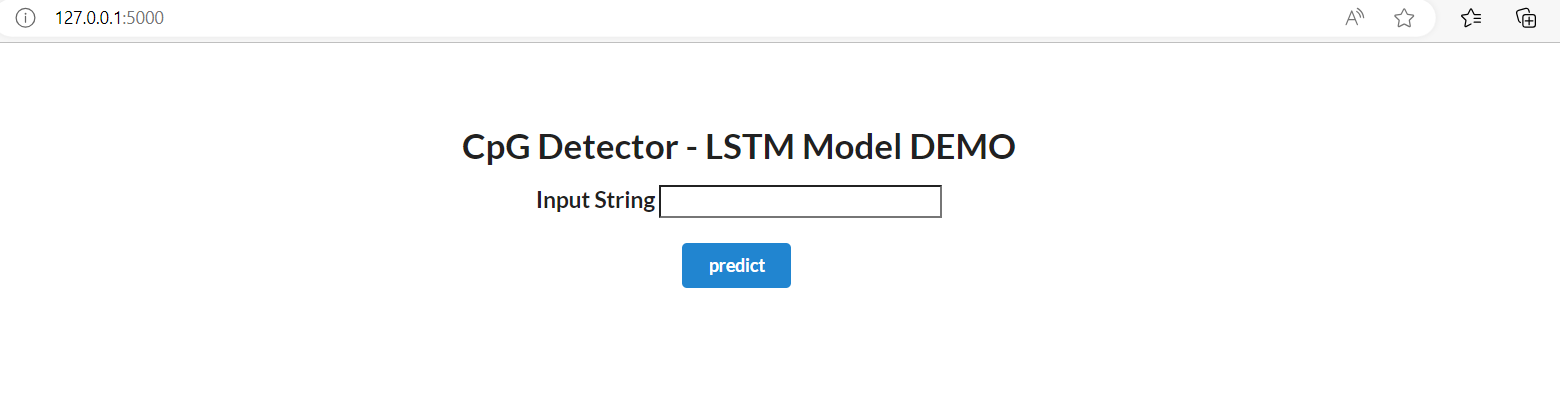

In [106]:
# import numpy as np
# from flask import Flask, request,render_template
# print('testing')
# from torch.autograd import Variable
# import torch.nn as nn
# import torch.optim as optim
# from typing import Sequence
# from functools import partial
# from torch.utils.data import Dataset, DataLoader
# print('testing')
# import pickle
# import torch 
# from functools import partial
# app = Flask(__name__)
# 
# 
# # Regression Model
# class LSTM(nn.Module):
# 
#     def __init__(self, num_classes, input_size, hidden_size, num_layers):
#         super(LSTM, self).__init__()
#         
#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                             num_layers=num_layers)
#         
#         self.fc = nn.Linear(hidden_size,self.num_classes)
#         self.relu = nn.ReLU()
# 
#     def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(1), self.hidden_size))
#         
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(1), self.hidden_size))
#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
#         
#         out = self.fc(h_out)
#         out = self.relu(out)
#         
#         return out
# 
# input_size = 128
# max_len = 128 
# hidden_size = 64
# num_layers = 1
# num_classes = 1
# batch_size = 16
# SAVED_MODEL = LSTM(num_classes, input_size, hidden_size, num_layers)
# SAVED_MODEL.load_state_dict(torch.load('saved_model.pth'))
# 
# @app.route('/',methods = ['GET'])
# def home():
#     return render_template('index.html')
# 
# 
# @app.route("/predict",methods=['POST'])
# def predict():
#     if request.method == 'POST':
#         Medu = request.form.get("Medu")	
#         # find the output using model
#         output = None 
#         def single_predict(test_sample):
# 
#             alphabet = 'NACGT'
#             dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
#             int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
#             dna2int.update({"pad": 0})
#             int2dna.update({0: "<pad>"})
# 
#             test_sample = list(test_sample)
#             print(test_sample)
#             test_sample = [dna2int[i] for i in test_sample]
#             test_sample = np.array(test_sample)
#             print(test_sample) 
#             with torch.inference_mode():
#                 observation = torch.from_numpy(np.array(test_sample)).float()
#                 temp_obs = torch.zeros(max_len-observation.shape[0])
#                 observation = torch.cat((observation,temp_obs),dim=0)
#                 observation = observation.unsqueeze(0).unsqueeze(0)
#                 observation_output = SAVED_MODEL(observation).item()
#                 return observation_output
#         
#         output = single_predict(Medu)
#         return render_template('index.html', prediction_text= "Lstm Model Prediction is {}".format(output))
#     else:
#         return render_template('index.html')
# 
#     
# if __name__ == "__main__":
#     app.run(debug=True)

## Template.html 

In [107]:
# <!DOCTYPE html>
# <html lang = 'en'>
# <head>
#     <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/semantic-ui@2.4.2/dist/semantic.min.css">
#     <meta name="viewport" content="width=device-width, initial-scale=1.0">
#     <meta charset = "UTF-8">
#     <title>CpG prediction</title>
# </head>
# <body>
#     <br><br>
#     <h1>CpG Detector - LSTM Model DEMO</h1>
#     <form action="{{url_for('predict')}}" method="post">
#         <div style="margin:0;padding:0">
#             <div>
#                 <h3 > Input String </h>
#                 <input id="feature1" name= "Medu"  type="text" required = "required" />
#             </div>
#             <br>
#             <button class="ui blue button" type="submit">predict</button>
#         </form>
#         <br><br><h3>{{ prediction_text }}</h3>     
#     </div>
# <style>
#     body {
#         background-color: rgb(255, 255, 255);
#         text-align: center;
#         font-family: sans-serif;
#         padding: 0px;
#     }   
# </style>
# </body>
# </html>

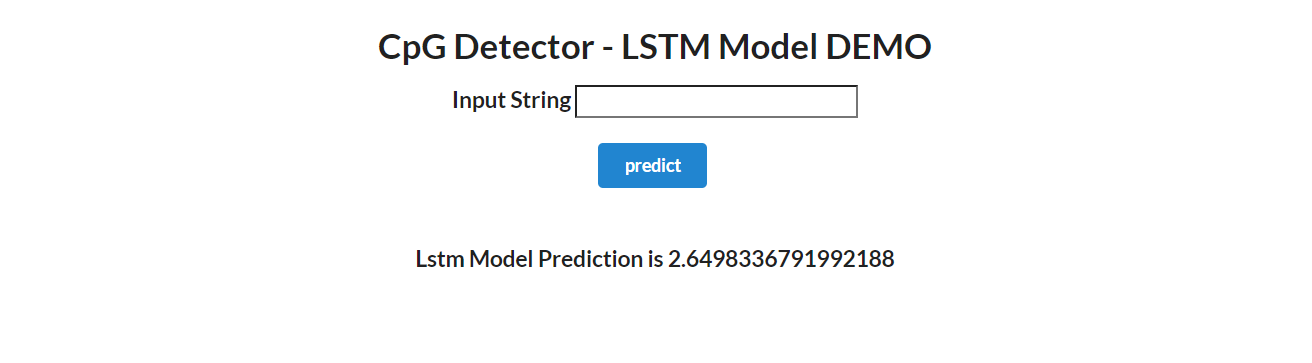